In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_validate

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Make the code reproducible
SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [45]:
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

# Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [46]:
df_all_declines = df_all_declines_original.copy()

# If the decline is longer than 4 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 4 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 4 * 4

# Add the decline outcome
df_all_declines['Recovered'] = df_all_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_all_declines['Category'] = df_all_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

# Add the channel's subs at the start of the decline
df_all_declines['Views_start'] = df_data_processed.loc[decline_index, 'views'].values

print(f"Overall recovery rate: {df_all_declines['Recovered'].mean():.2f}")

df_all_declines.head()

Overall recovery rate: 0.46


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start
0,UCi8IX8CVCHRKiLV_eCWEKNA,20,False,117,137,People & Blogs,32974.875000,1,1.842075e+06
1,UCi8IX8CVCHRKiLV_eCWEKNA,28,False,190,218,People & Blogs,150182.875000,3,1.236850e+07
2,UCW4jUKddkdTJwl3EFlc8ZMQ,13,True,218,231,Film and Animation,12939.125000,0,4.470020e+06
3,UC_hZX0wqyjq3CabYF25ol8Q,18,False,224,242,Gaming,16797.444444,4,5.939868e+06
4,UC-TDzpXxJndgBvyX4dZXVzA,29,False,172,201,Music,22794.200000,0,3.953500e+06


# How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we plot some distributions.

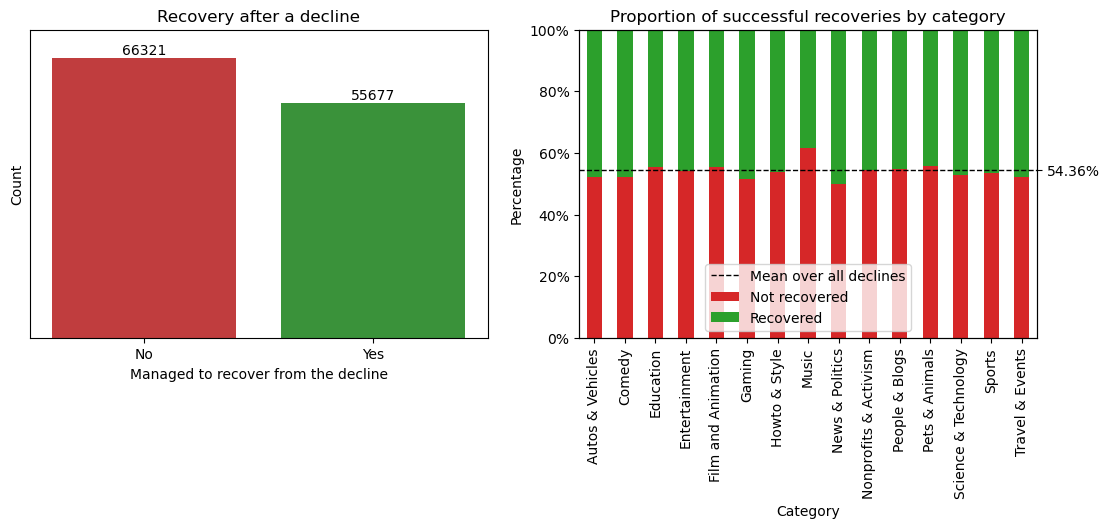

In [47]:
plot_recovered_by_categories(df_all_declines)

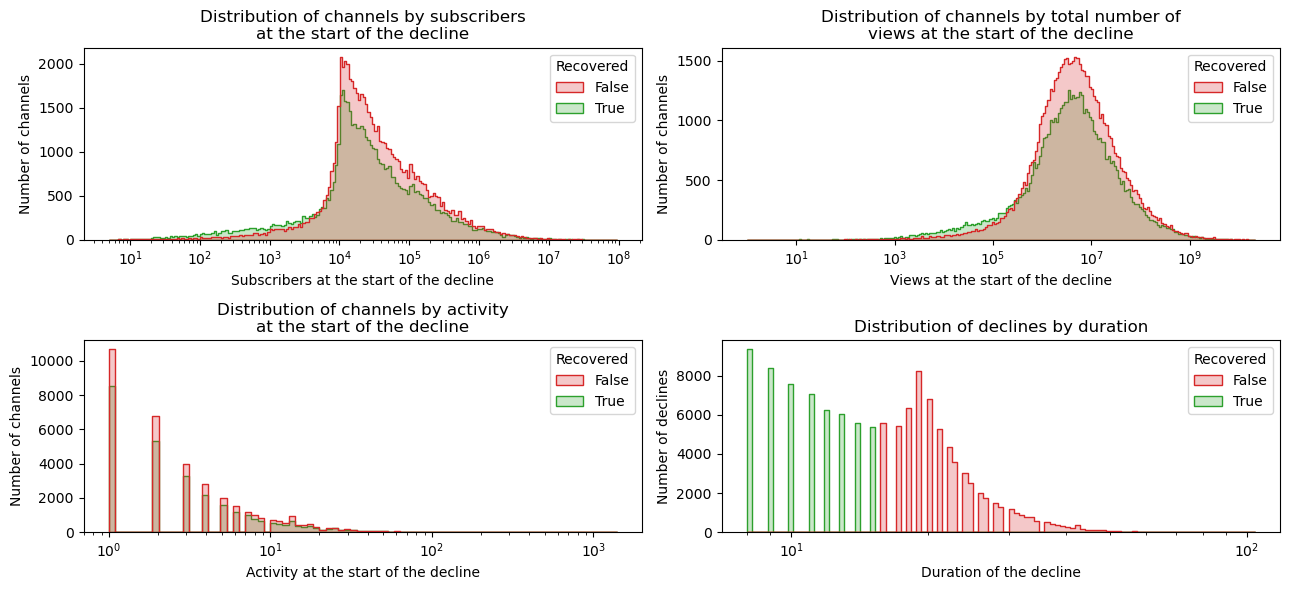

In [48]:
plot_group_distributions(df_all_declines)

We can observe that some features are not balanced between the declines that recovered and those that did not, especially views and subscribers at the start of the decline.

In [49]:
print(df_all_declines['Recovered'].value_counts())
print(f"\nTotal number of declines: {len(df_all_declines)}")

Recovered
False    66321
True     55677
Name: count, dtype: int64

Total number of declines: 121998


# YouTuber reactions

Aiming at finding the best ways to deal with a decline depending on the situation, we take a look at how the YouTubers reacted to the decline, and what methods proved effective.\
In order to observe the reaction's impact, we will conduct a matched observational study on the dataset by using propensity score matching.

Considering the size of the dataset, we use random sampling to ease the matching's computation.\
To check that sampling does not mess with the distribution of recoveries, we plot them depending on the sampling proportion.

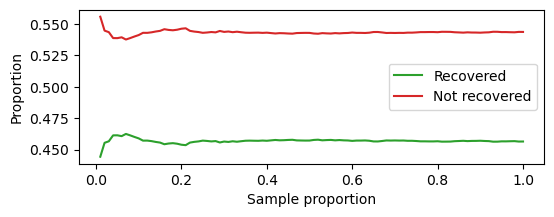

In [50]:
plot_sampling_rates(df_all_declines, SEED)

We choose to sample 30% of the data since it considerably reduces the size of the dataset, and allows to keep a representative sample of the data without perturbing the recovery distribution.

In [51]:
df_sampled = df_all_declines.sample(frac=0.3, replace=False, random_state=SEED)

print(df_sampled['Recovered'].value_counts())
print(f"\nTotal number of declines after sampling: {len(df_sampled)}")

# Save the data for the plots
df_sampled.to_csv('plot_data/decline_events.csv', index=False)

Recovered
False    19897
True     16702
Name: count, dtype: int64

Total number of declines after sampling: 36599


### Adding the reaction metrics whose impact we want to measure

The reactions that we are able to observe here are the following:
- Did the YouTuber change video publication frequency?
- Did the YouTuber change video length?
- Did the YouTuber change video category?

In [52]:
# Load the videos around the declines, from week (decline start - decline duration) to week (decline end)
videos_around_declines = pd.read_csv('data/videos_around_declines.csv')

# Add the declines with the indices of the corresponding videos
df_sampled = get_sampled_declines_with_videos(df_sampled, videos_around_declines)

# Augment the data with the video stats : videos per week and mean video duration, before and during the declines
df_sampled = add_video_stats(df_sampled, videos_around_declines)

DIV_BY_ZERO_TOLERANCE = 1e-6

# Indicate whether the channel increased mean video duration after the start of the decline. We include a tolerance of 50% change.
df_sampled['Mean_duration_difference'] = df_sampled.apply(lambda row: row['Mean_duration_after'] - row['Mean_duration_before'], axis=1)
df_sampled['Posted_longer_videos'] = df_sampled.apply(lambda row: (row['Mean_duration_difference']) / np.max([row['Mean_duration_before'], DIV_BY_ZERO_TOLERANCE]) > 0.5, axis=1)
df_sampled['Posted_shorter_videos'] = df_sampled.apply(lambda row: (row['Mean_duration_difference']) / np.max([row['Mean_duration_before'], DIV_BY_ZERO_TOLERANCE]) < -0.5, axis=1)
print(f"\n{df_sampled['Posted_longer_videos'].mean() * 100:.2f}% of the channels posted longer videos after the start of the decline.")
print(f"{df_sampled['Posted_shorter_videos'].mean() * 100:.2f}% of the channels posted shorter videos after the start of the decline.\n")

# Indicate whether the channel changed publishing frequency after the start of the decline. We include a tolerance of 100% change (doubling the frequency).
df_sampled['Mean_frequency_difference'] = df_sampled.apply(lambda row: row['Videos_per_week_after'] - row['Videos_per_week_before'], axis=1)
df_sampled['Posted_more'] = df_sampled.apply(lambda row: (row['Mean_frequency_difference']) / np.max([row['Videos_per_week_before'], DIV_BY_ZERO_TOLERANCE]) > 0.5, axis=1)
df_sampled['Posted_less'] = df_sampled.apply(lambda row: (row['Mean_frequency_difference']) / np.max([row['Videos_per_week_before'], DIV_BY_ZERO_TOLERANCE]) < -0.5, axis=1)
print(f"{df_sampled['Posted_more'].mean() * 100:.2f}% of the channels posted more videos after the start of the decline.")
print(f"{df_sampled['Posted_less'].mean() * 100:.2f}% of the channels posted less videos after the start of the decline.")

# Adding three columns for the topic of the videos before and after the decline, and whether the topic changed or not
topic_change_data = pd.read_csv('data/df_topic_change_20_15w.csv')
topic_change_data.columns = ['Decline', 'Topic_Change', 'Topic_Before', 'Topic_After']
df_sampled = pd.merge(df_sampled, topic_change_data, left_index=True, right_on='Decline', how='left')
print(f"{df_sampled['Topic_Change'].mean() * 100:.2f}% of the channels changed of topic after the start of the decline.")
df_sampled = df_sampled.drop(columns=['Decline', 'Topic_Before', 'Topic_After'])


# Drop the declines with missing data (usually due to having no video before or after the decline, or no category)
df_sampled = df_sampled.dropna()

# Put the differences aside, to be used later but not in the models
df_videos_per_week = df_sampled[['Videos_per_week_before', 'Videos_per_week_after']]
df_video_duration = df_sampled[['Mean_duration_before', 'Mean_duration_after']] 
df_sampled = df_sampled.drop(['Mean_duration_before', 'Mean_duration_after'], axis=1)
df_sampled = df_sampled.drop(['Videos_per_week_before', 'Videos_per_week_after'], axis=1)

# Keep a copy of the declines that have videos before and after the decline
df_sampled_without_zero_videos = df_sampled[(df_sampled['Videos_before'].apply(len) > 0) & (df_sampled['Videos_after'].apply(len) > 0)]

# Drop the indices of the videos, they are not needed anymore
df_sampled = df_sampled.drop(['Videos_before', 'Videos_after'], axis=1)
df_sampled_without_zero_videos = df_sampled_without_zero_videos.drop(['Videos_before', 'Videos_after'], axis=1)

df_sampled.head()

Sampled declines with videos loaded from file.

12.08% of the channels posted longer videos after the start of the decline.
6.52% of the channels posted shorter videos after the start of the decline.

22.65% of the channels posted more videos after the start of the decline.
24.69% of the channels posted less videos after the start of the decline.
36.41% of the channels changed of topic after the start of the decline.


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Mean_duration_difference,Posted_longer_videos,Posted_shorter_videos,Mean_frequency_difference,Posted_more,Posted_less,Topic_Change
0.0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.753062e+07,419.748120,True,False,-0.250000,False,False,False
1.0,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,2.758465e+07,1432.453191,True,False,-1.214286,False,False,False
2.0,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,3.935174e+06,-177.302463,False,False,0.428571,False,False,False
3.0,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,2.818956e+06,-249.533333,False,False,-0.600000,False,False,False
4.0,UCMn7t0wYUevjBqhK9PUGfHA,19,False,154,173,Music,14582.750000,1,9.031720e+05,-38.000000,False,False,-0.210526,False,True,False


### Propensity score matching

Seeing that the declines do not have the same distribution on their features, we perform propensity score matchings to balance the treatment and control groups looking at the effect that changing publication frequency,video duration and video category after the start of the decline have on the recovery.

After the propensity score matching, we can observe the effect of the different treatments on the recovery :

Matches loaded from file for treatment Posted_more.
Posted_more matches : [(30428.0, 6.0), (9131.0, 24.0), (18392.0, 27.0), (19141.0, 29.0), (9466.0, 33.0), (14123.0, 34.0), (6750.0, 50.0), (31566.0, 57.0), (9719.0, 58.0), (31553.0, 59.0), (511.0, 65.0), (24045.0, 70.0), (28683.0, 84.0), (22746.0, 97.0), (16620.0, 99.0), (3883.0, 100.0), (3697.0, 101.0), (19848.0, 121.0), (20797.0, 125.0), (20027.0, 128.0), (4143.0, 131.0), (8864.0, 132.0), (26971.0, 133.0), (25911.0, 134.0), (2260.0, 137.0), (24891.0, 149.0), (8493.0, 153.0), (1067.0, 159.0), (8206.0, 162.0), (13476.0, 173.0), (1056.0, 189.0), (21415.0, 199.0), (29978.0, 203.0), (20487.0, 215.0), (27942.0, 223.0), (24953.0, 227.0), (21994.0, 236.0), (6913.0, 243.0), (26593.0, 249.0), (934.0, 250.0), (25751.0, 254.0), (14407.0, 262.0), (26904.0, 271.0), (11659.0, 292.0), (10343.0, 293.0), (18325.0, 298.0), (20583.0, 303.0), (1978.0, 304.0), (13735.0, 311.0), (21969.0, 315.0), (25315.0, 316.0), (9406.0, 320.0), (7174.0, 321.0), (23104.0

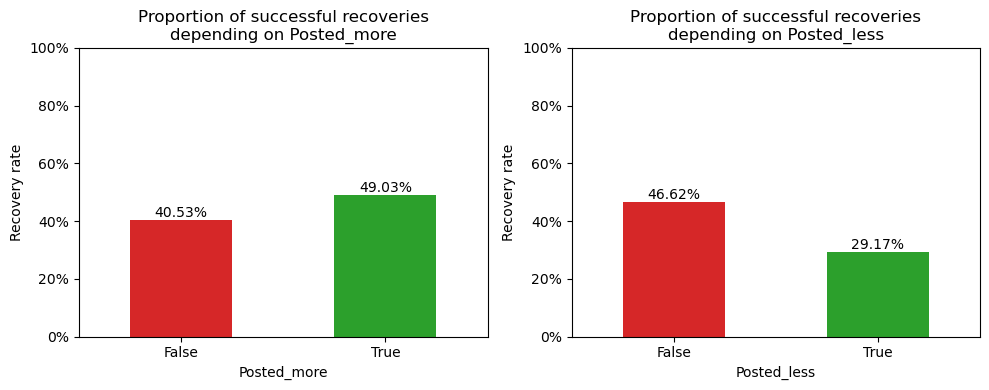

Matches loaded from file for treatment Posted_longer_videos.
Posted_longer_videos matches : [(28230.0, 0.0), (4857.0, 1.0), (7358.0, 18.0), (28630.0, 30.0), (12910.0, 33.0), (7708.0, 61.0), (27596.0, 75.0), (12646.0, 84.0), (23655.0, 100.0), (25398.0, 101.0), (16418.0, 113.0), (9201.0, 120.0), (7318.0, 129.0), (10538.0, 130.0), (5056.0, 137.0), (24844.0, 142.0), (28732.0, 143.0), (16462.0, 145.0), (11641.0, 156.0), (6731.0, 159.0), (1021.0, 190.0), (10548.0, 199.0), (29893.0, 200.0), (23369.0, 205.0), (6365.0, 211.0), (16036.0, 215.0), (9635.0, 228.0), (23881.0, 236.0), (18572.0, 245.0), (3607.0, 247.0), (18080.0, 254.0), (26329.0, 261.0), (2832.0, 266.0), (5698.0, 278.0), (5905.0, 286.0), (10716.0, 298.0), (4046.0, 300.0), (15318.0, 303.0), (13415.0, 304.0), (12341.0, 318.0), (21297.0, 320.0), (22350.0, 322.0), (15494.0, 325.0), (11505.0, 329.0), (363.0, 333.0), (9723.0, 336.0), (14315.0, 338.0), (13796.0, 342.0), (7931.0, 343.0), (28938.0, 346.0), (6777.0, 350.0), (9590.0, 371.0), (2

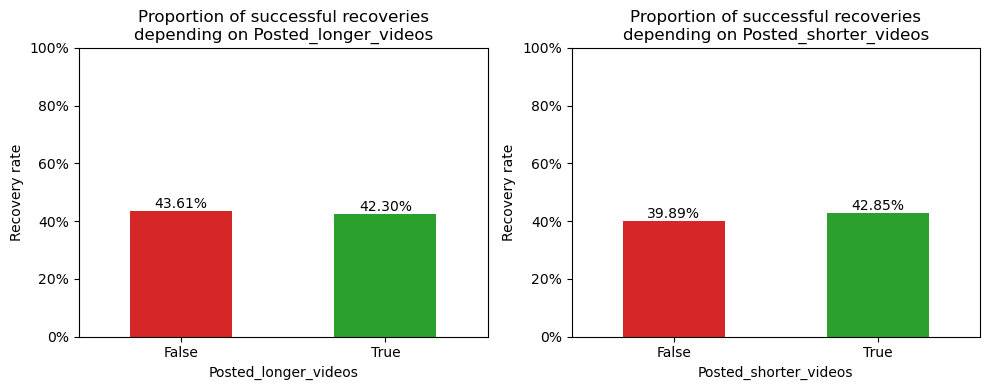

Matches loaded from file for treatment Topic_Change.
Topic_Change matches : [(3840.0, 5.0), (30615.0, 7.0), (29800.0, 11.0), (4201.0, 15.0), (11823.0, 18.0), (15947.0, 22.0), (16943.0, 27.0), (7217.0, 49.0), (28840.0, 56.0), (6583.0, 57.0), (27815.0, 58.0), (3565.0, 62.0), (27548.0, 74.0), (17269.0, 78.0), (23712.0, 91.0), (26919.0, 105.0), (546.0, 109.0), (20736.0, 111.0), (6916.0, 122.0), (11347.0, 131.0), (9414.0, 137.0), (11012.0, 138.0), (15425.0, 153.0), (23830.0, 155.0), (6064.0, 163.0), (21011.0, 177.0), (31324.0, 190.0), (13905.0, 202.0), (2951.0, 203.0), (25002.0, 210.0), (9895.0, 214.0), (8181.0, 233.0), (4140.0, 241.0), (2310.0, 242.0), (5572.0, 245.0), (25115.0, 253.0), (8616.0, 264.0), (25186.0, 266.0), (6542.0, 281.0), (12525.0, 284.0), (8821.0, 285.0), (19263.0, 288.0), (2729.0, 289.0), (17181.0, 293.0), (21391.0, 297.0), (11055.0, 298.0), (5101.0, 300.0), (5077.0, 302.0), (26902.0, 306.0), (2700.0, 314.0), (29105.0, 317.0), (22671.0, 324.0), (21345.0, 330.0), (2458.0, 

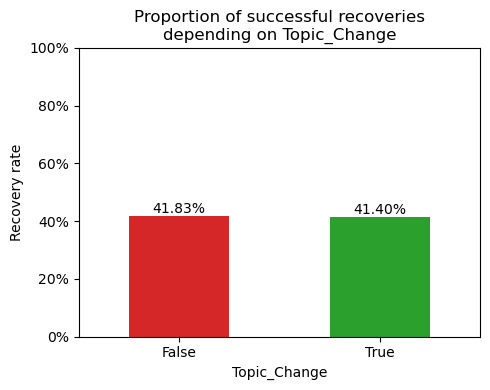

In [53]:
# The variables to be used for the matching
# Treatments in the same array will be plotted together
TREATMENTS = [
    ['Posted_more',
    'Posted_less'],
    ['Posted_longer_videos',
    'Posted_shorter_videos'],
    ['Topic_Change']
]

# The variables to be dropped for each treatment (to avoid multicollinearity or strong correlation)
# Use the same order as the TREATMENTS array
to_drop = [
    [['Mean_frequency_difference', 'Posted_less'],
    ['Mean_frequency_difference', 'Posted_more']],
    [['Mean_duration_difference', 'Posted_shorter_videos'],
    ['Mean_duration_difference', 'Posted_longer_videos']],
    [[]]
]

plot_df = pd.DataFrame(columns=['Strategy', 'Adopted the strategy', 'Did not adopt'])

matched_dfs = {}
for plot_treatments, plot_dropped in zip(TREATMENTS, to_drop):
    fig, axes = plt.subplots(1, len(plot_treatments), figsize=(5*len(plot_treatments), 4))
    for subplot_id, (treatment, dropped) in enumerate(zip(plot_treatments, plot_dropped)):

        # Try to load the matches from the file, otherwise compute them
        matches = get_matches(treatment=treatment, declines=df_sampled.drop(dropped, axis=1), verbose=False)

        print(f"{treatment} matches :", matches)

        # Flatten
        matches = [index for match in matches for index in match]

        # Get the matched declines
        matched_dfs[treatment] = df_sampled.loc[matches]

        counts = matched_dfs[treatment].groupby(treatment)['Recovered'].mean() * 100
        plot_df.loc[len(plot_df)] = [treatment, counts[True], counts[False]]

        plot_treatment_effect(matched_dfs[treatment], treatment, ax=axes[subplot_id] if len(plot_treatments) > 1 else axes)

    plt.tight_layout()
    plt.show()

plot_df.to_csv('plot_data/matches_results.csv', index=False)

### 2. Decision tree

Decision tree accuracy: 0.59


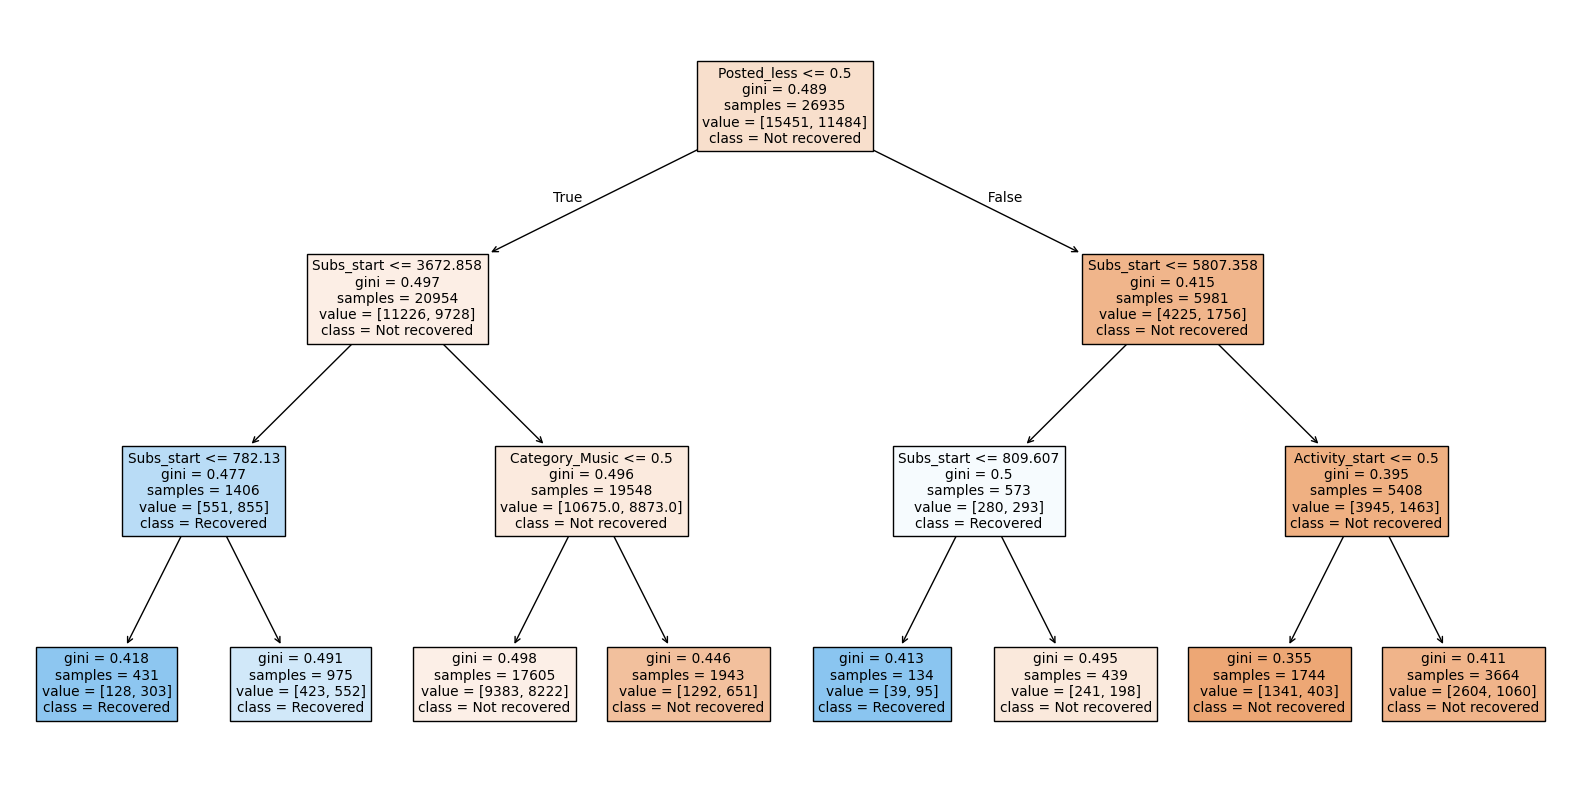

In [54]:
def perform_decision_tree(X, y):
    # Create the decision tree model
    tree = DecisionTreeClassifier(max_depth=3, random_state=SEED)

    # Evaluate the model using cross-validation
    cv_results = cross_validate(tree, X, y, cv=5, scoring='accuracy')

    # Fit the model on the whole dataset
    tree.fit(X, y)

    return tree, cv_results

drop_cols = ['Channel', 'Start', 'End', 'Duration', 'Recovered', 'Mean_duration_difference', 'Mean_frequency_difference']

tree_X = df_sampled.drop(drop_cols, axis=1)
tree_X = pd.get_dummies(tree_X, columns=['Category'], drop_first=True)

tree_y = df_sampled['Recovered']

tree, cv_results = perform_decision_tree(tree_X, tree_y)

print(f"Decision tree accuracy: {cv_results['test_score'].mean():.2f}")

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=tree_X.columns, class_names=['Not recovered', 'Recovered'])
plt.show()

# New Start 

In [55]:
df_sampled.head()

,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Mean_duration_difference,Posted_longer_videos,Posted_shorter_videos,Mean_frequency_difference,Posted_more,Posted_less,Topic_Change
0.0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.753062e+07,419.748120,True,False,-0.250000,False,False,False
1.0,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,2.758465e+07,1432.453191,True,False,-1.214286,False,False,False
2.0,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,3.935174e+06,-177.302463,False,False,0.428571,False,False,False
3.0,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,2.818956e+06,-249.533333,False,False,-0.600000,False,False,False
4.0,UCMn7t0wYUevjBqhK9PUGfHA,19,False,154,173,Music,14582.750000,1,9.031720e+05,-38.000000,False,False,-0.210526,False,True,False


## Summary Statistics 

In [56]:
df_sampled.describe()

,Duration,Start,End,Subs_start,Activity_start,Views_start,Mean_duration_difference,Mean_frequency_difference
count,26935.000000,26935.000000,26935.000000,2.693500e+04,26935.000000,2.693500e+04,26935.000000,26935.000000
mean,17.871357,172.006980,189.878337,1.655763e+05,4.537628,3.806526e+07,3.541893,-0.230678
std,7.771222,39.111496,39.522963,7.598811e+05,14.721962,2.660578e+08,1040.367686,3.844360
min,8.000000,67.000000,80.000000,7.000000e+00,0.000000,2.405000e+02,-35228.000000,-237.000000
25%,12.000000,141.000000,158.000000,1.190941e+04,0.000000,1.432966e+06,-93.821078,-0.517241
50%,17.000000,177.000000,197.000000,2.556035e+04,2.000000,4.483128e+06,2.810025,-0.083333
75%,22.000000,203.000000,222.000000,8.487342e+04,4.000000,1.561427e+07,113.537140,0.214286
max,97.000000,239.000000,247.000000,2.833122e+07,1391.000000,1.463010e+10,26581.333333,170.125000


## Correlation Analysis

In [57]:
df_sampled.head()

,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Mean_duration_difference,Posted_longer_videos,Posted_shorter_videos,Mean_frequency_difference,Posted_more,Posted_less,Topic_Change
0.0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.753062e+07,419.748120,True,False,-0.250000,False,False,False
1.0,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,2.758465e+07,1432.453191,True,False,-1.214286,False,False,False
2.0,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,3.935174e+06,-177.302463,False,False,0.428571,False,False,False
3.0,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,2.818956e+06,-249.533333,False,False,-0.600000,False,False,False
4.0,UCMn7t0wYUevjBqhK9PUGfHA,19,False,154,173,Music,14582.750000,1,9.031720e+05,-38.000000,False,False,-0.210526,False,True,False


In [58]:
# Transform the categorical variable into dummies
df_sampled_processed = pd.get_dummies(df_sampled, columns=['Category'], drop_first=True)

# Transform the boolean variables into integers
df_sampled_processed['Recovered'] = df_sampled_processed['Recovered'].astype(int)
df_sampled_processed['Posted_more'] = df_sampled_processed['Posted_more'].astype(int)
df_sampled_processed['Posted_less'] = df_sampled_processed['Posted_less'].astype(int)
df_sampled_processed['Posted_longer_videos'] = df_sampled_processed['Posted_longer_videos'].astype(int)
df_sampled_processed['Posted_shorter_videos'] = df_sampled_processed['Posted_shorter_videos'].astype(int)
df_sampled_processed['Topic_Change'] = df_sampled_processed['Topic_Change'].astype(int)


# Calculate the correlation matrix
correlation_matrix = df_sampled_processed.drop(columns=['Channel']).corr()

# Display the correlation matrix
print(correlation_matrix['Recovered'].sort_values(ascending=False))

Recovered                         1.000000
Posted_more                       0.066548
Mean_frequency_difference         0.049357
Category_Gaming                   0.042258
Start                             0.035796
Category_News & Politics          0.017840
Subs_start                        0.012223
Category_Howto & Style            0.010259
Category_Science & Technology     0.009884
Activity_start                    0.005741
Category_People & Blogs           0.004735
Views_start                       0.004265
Category_Comedy                   0.003814
Category_Travel & Events          0.003144
Category_Sports                   0.002516
Posted_longer_videos             -0.001292
Posted_shorter_videos            -0.001773
Category_Pets & Animals          -0.002578
Category_Entertainment           -0.004761
Mean_duration_difference         -0.007647
Category_Nonprofits & Activism   -0.008040
Category_Film and Animation      -0.008602
Topic_Change                     -0.014018
Category_Ed

**Summary**:

* **Positive Correlations** : Posting more videos, changes in upload frequency, and certain categories (e.g., Gaming, News & Politics) are slightly associated with recovery.

* **Negative Correlations** : Longer decline durations and posting fewer videos are more strongly associated with lower chances of recovery.

## Visual Analysis

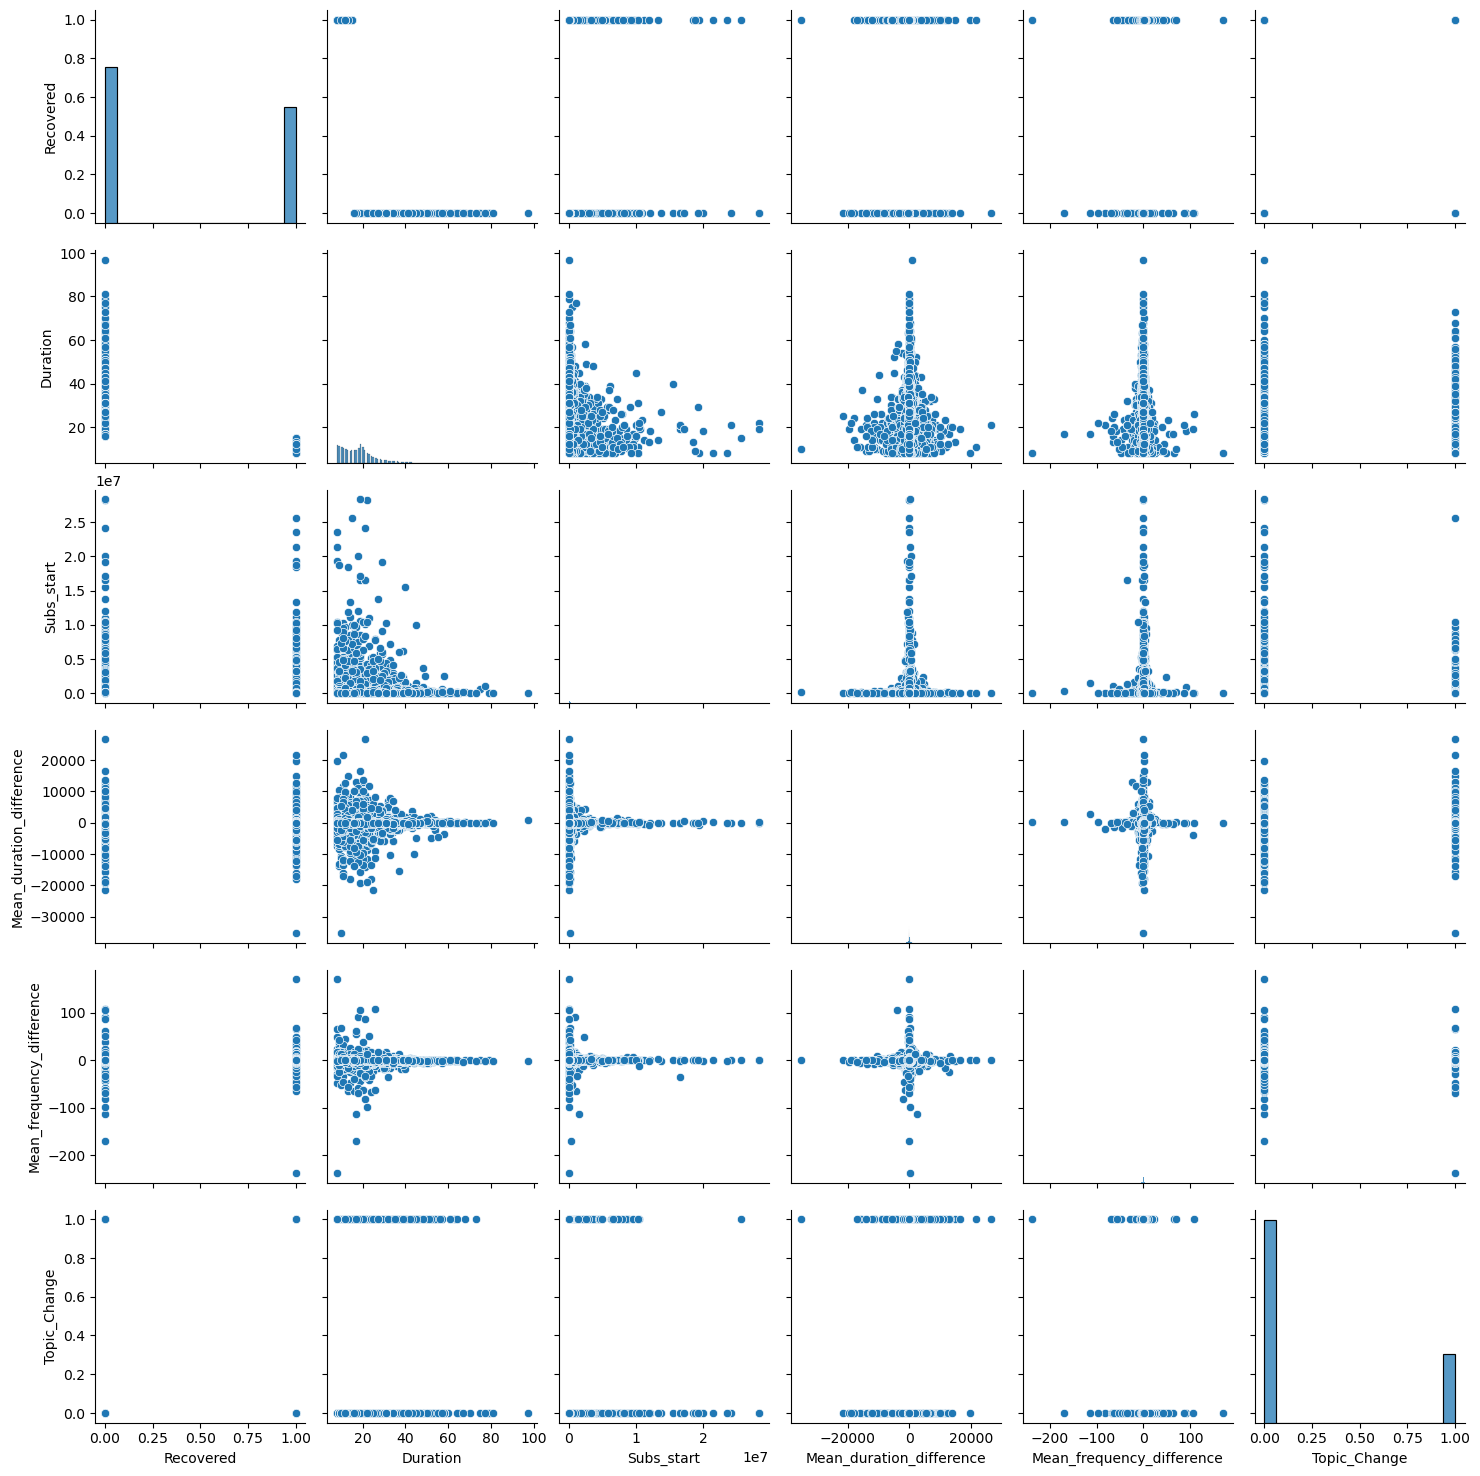

In [59]:
# Pairplot to visualize relationships
sns.pairplot(df_sampled_processed, vars=['Recovered', 'Duration', 'Subs_start', 'Mean_duration_difference', 'Mean_frequency_difference', 'Topic_Change'])
plt.show()

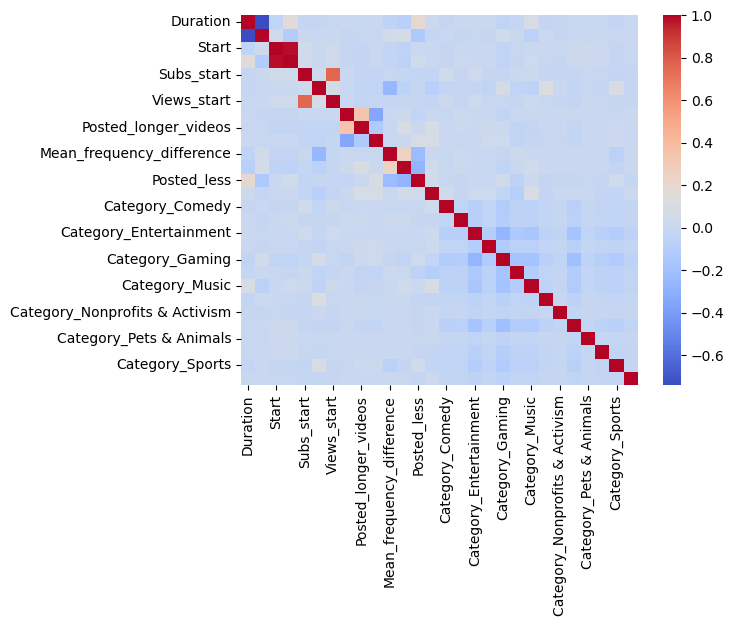

In [60]:
# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

**Thoughts :** This visual analysis confirm the correlation analysis 

## Feature importance analysis 

First, do the regression on all the declines that we kept until now.

As a sanity check, we run the same regression, removing the declines that have no videos either before, during or both to check that the presence of zeros does not have a significant impact on the results.

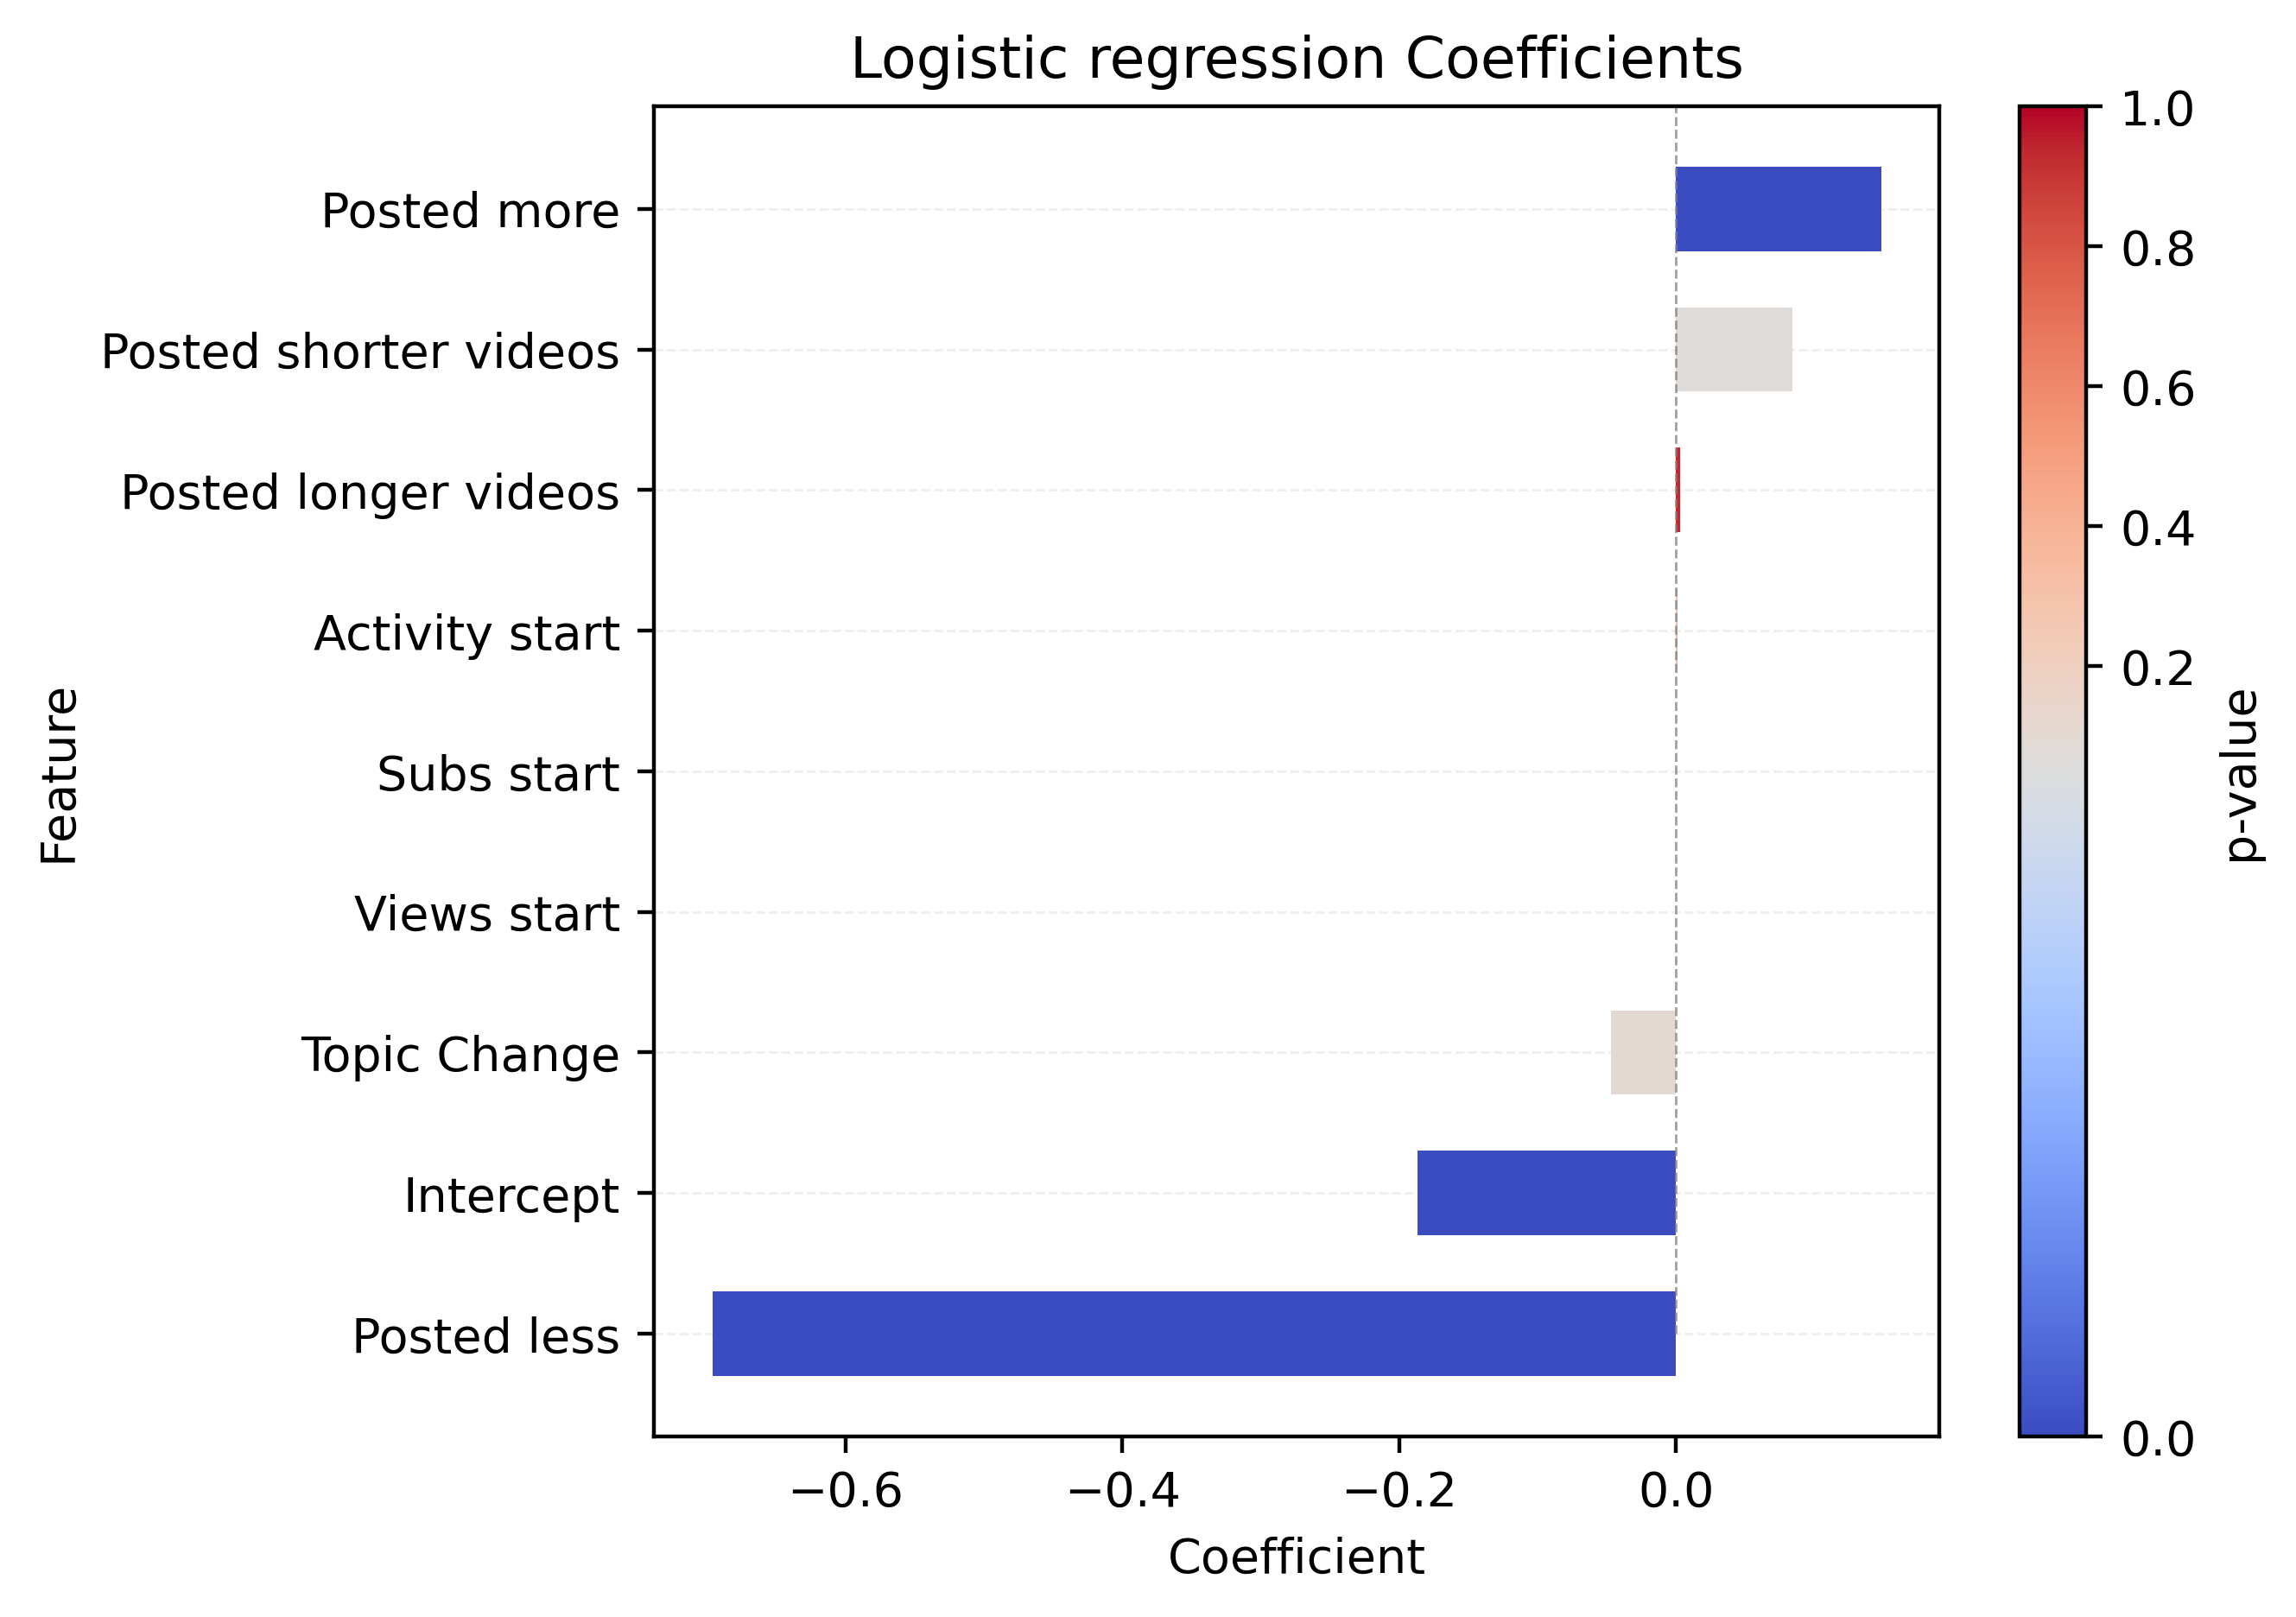

In [61]:
# Columns that are not included in the regression
drop_cols = ['Channel', 'Start', 'End', 'Duration', 'Recovered', 'Mean_duration_difference', 'Mean_frequency_difference', 'Category']

# Prepare the data for the logistic regression
logit_X = df_sampled.drop(drop_cols, axis=1)
logit_y = df_sampled['Recovered']

# Perform the regression
logit_result = perform_logistic_regression(logit_X, logit_y)

plt.figure(figsize=(6, 5), dpi=400)
plot_logit_coefficients(logit_result, title='Logistic regression Coefficients', filename='logit_coefficients.png')

# Save the coefficients, p-values and variable names to a file for plotting
with open('plot_data/logit_results.csv', 'w') as f:
    res = pd.DataFrame({'coef': logit_result.params, 'p-value': logit_result.pvalues}).reset_index()
    res.columns = ['Variable', 'Coefficient', 'p-value']
    res.to_csv(f, index=False)


**Key Insights:**

* **Posted_more**:  Posting more videos during the decline period significantly increases the chances of recovery.

* **Posted_shorter_videos** : Posting shorter videos has a marginally significant positive effect on recovery.

* **Subs_start** : The number of subscribers at the start of the decline has a marginally significant positive effect on recovery.

* **Posted_less** : Posting fewer videos significantly decreases the chances of recovery.

* **Category Impact**: Categories with positive coefficients (e.g., Gaming, News & Politics) are more likely to recover. Focus on content that fits these categories.


**Actionable Advice:**

* **Increase Video Uploads** : Consistently post more videos during the decline period to engage your audience and increase the chances of recovery.

* **Avoid Reducing Uploads** : Avoid posting fewer videos, as this significantly decreases the chances of recovery.

* **Consider Video Length** : Posting shorter videos may have a positive impact on recovery.

* **Focus on Content Categories** : If possible, avoid focusing solely on Education and Music categories, as these are associated with lower recovery rates.

* **Leverage Subscriber Base** : Engage with your existing subscribers to maximize their support during the decline period.

### Let's look at how we could answer to Youtuber's questions 

Here are some potential questions that a Youtube cerator could ask us, let's understand which one we could answer : 

1. How often should I post new videos?

2. Should I focus on shorter or longer videos?
**Answer**: This can depend on your audience's preferences. Analyze your video performance data to see if shorter or longer videos perform better. You can also experiment with different lengths to find the optimal duration for your content.

3. What type of content should I focus on?
**Answer**: Focus on content that has historically performed well on your channel. Additionally, consider creating content that fits into popular categories like Gaming or News & Politics, as these have shown higher recovery rates.

4. How can I maintain quality while increasing quantity?
**Answer**: Plan your content in advance and create a content calendar. Batch filming and editing can also help you maintain quality while increasing the number of videos you post.

5. Will posting more videos affect my channel's overall quality?
**Answer**: It's important to strike a balance between quantity and quality. Ensure that each video provides value to your audience. If necessary, consider outsourcing tasks like editing to maintain quality.

6. How can I keep my audience engaged with more frequent uploads?
**Answer**: Engage with your audience through comments, community posts, and live streams. Ask for their feedback and involve them in your content creation process to keep them interested.

7. What if I don't see immediate results from posting more videos?
**Answer**: Recovery can take time, so be patient and consistent. Monitor your analytics to track progress and make adjustments as needed. Consistency is key to building and maintaining audience engagement.

8. How can I come up with more video ideas?
**Answer**: Use tools like YouTube Analytics, Google Trends, and social media to identify trending topics and popular content in your niche. Engage with your audience to get ideas and feedback on what they want to see.

9. What other strategies can complement posting more videos?
**Answer**: In addition to posting more videos, focus on optimizing your video titles, descriptions, and tags for SEO. Collaborate with other creators, promote your videos on social media, and engage with your audience to boost visibility and engagement.

10. How do I measure the success of posting more videos?
**Answer**: Use YouTube Analytics to track key metrics such as views, watch time, subscriber growth, and engagement. Compare these metrics before and after increasing your upload frequency to measure the impact.



## Q1 : How often should I post new videos?
We saw that **uploading more videos** should help to maximize the chances of recovery. Hence we should look at how many videos we should advise him to post each week 

As `Posted_more` has a positive impact on recovery, we want to look into what situations benefit the most from posting videos more often.

We therefore look at the characteristics of decline which reacted that way, and when it worked best :

- Did channels who increased publication frequency already post often, or did they post few videos before the
- Is posting more often associated with a lower average video duration?

In [62]:
# Build a new dataframe useful for reaction analysis
kept_cols = ['Channel', 'Duration', 'Start', 'End', 'Posted_more', 'Posted_less', 'Posted_longer_videos', 'Posted_shorter_videos', 'Recovered', 'Mean_duration_difference', 'Mean_frequency_difference']
df_reactions = pd.concat([df_sampled[kept_cols], df_videos_per_week, df_video_duration], axis=1)

df_reactions['No_change'] = ~df_reactions['Posted_more'] & ~df_reactions['Posted_less']
df_reactions['Frequency_reaction'] = pd.from_dummies(df_reactions[['Posted_more', 'Posted_less', 'No_change']])
df_reactions = df_reactions.drop(['Posted_more', 'Posted_less', 'No_change'], axis=1)

df_reactions['No_change'] = ~df_reactions['Posted_longer_videos'] & ~df_reactions['Posted_shorter_videos']
df_reactions['Video_duration_reaction'] = pd.from_dummies(df_reactions[['Posted_longer_videos', 'Posted_shorter_videos', 'No_change']])
df_reactions = df_reactions.drop(['Posted_longer_videos', 'Posted_shorter_videos', 'No_change'], axis=1)

df_reactions

,Channel,Duration,Start,End,Recovered,Mean_duration_difference,Mean_frequency_difference,Videos_per_week_before,Videos_per_week_after,Mean_duration_before,Mean_duration_after,Frequency_reaction,Video_duration_reaction
0.0,UC3B6FyoLMLrUYa6i72ccPvw,20,189,209,False,419.748120,-0.250000,0.950000,0.700000,566.894737,986.642857,No_change,Posted_longer_videos
1.0,UCIHBFO-XMyTpzXAN-lg8o2g,14,112,126,True,1432.453191,-1.214286,3.357143,2.142857,1095.446809,2527.900000,No_change,Posted_longer_videos
2.0,UC2MjZanWOfyfsrHOyitmXbQ,14,128,142,True,-177.302463,0.428571,2.071429,2.500000,721.931034,544.628571,No_change,No_change
3.0,UCgUtduvq2Wpc7CDHcGDmZog,15,188,203,True,-249.533333,-0.600000,1.600000,1.000000,921.666667,672.133333,No_change,No_change
4.0,UCMn7t0wYUevjBqhK9PUGfHA,19,154,173,False,-38.000000,-0.210526,0.263158,0.052632,209.000000,171.000000,Posted_less,No_change
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31635.0,UC1K0dOUXlTyaDODIxpTBBwQ,17,205,222,False,-188.198701,-0.882353,4.117647,3.235294,711.471429,523.272727,No_change,No_change
31638.0,UCFc1q8NjbBh_MHJvYP_sbsg,16,224,240,False,-229.513258,1.062500,1.000000,2.062500,859.937500,630.424242,Posted_more,No_change
31639.0,UCIPdIlv1EIGyTSfFAfV0Eag,10,236,246,True,-39.500000,0.100000,0.100000,0.200000,184.000000,144.500000,Posted_more,No_change
31640.0,UCDmxnPem-pPfJQATIkfgY2Q,41,201,242,False,-412.850549,-0.219512,0.853659,0.634146,2475.542857,2062.692308,No_change,No_change


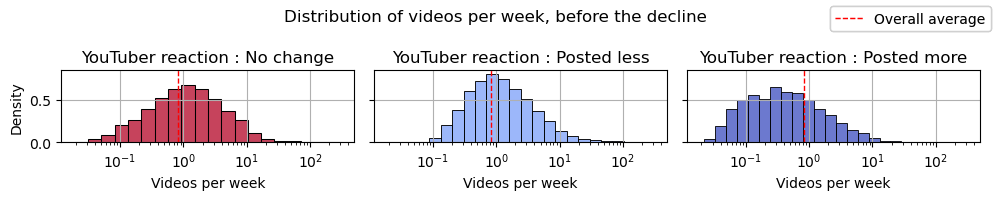

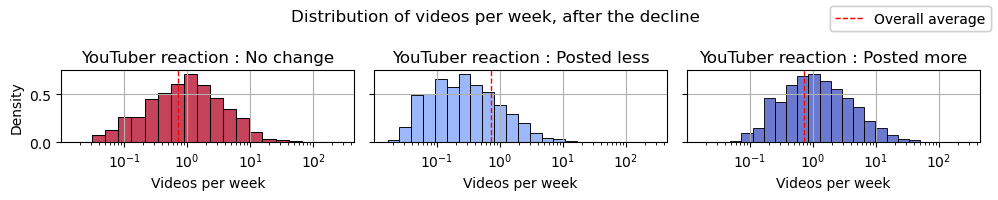

In [63]:
plot_distribution_by_frequency_reaction(df_reactions, 'Videos_per_week_before', 'Distribution of videos per week, before the decline')
plot_distribution_by_frequency_reaction(df_reactions, 'Videos_per_week_after', 'Distribution of videos per week, after the decline')
plt.show()

**Plot description :**

* In red are the channels that during their decline didn't change the frequency of their publications, we plot the ditribution of videos published before and after their decline.

* In light blue are the channels that during they declined decreased the frequency of their publications, we plot the distribution of videos published before and after their decline.

* In dark blue are the channels that during they declined increased the frequency of their publications, we plot the distribution of videos published before and after their decline.

* The red line represents the average number of videos published before/after the decline.

It is interesting to note that the channels that increased video frequency after the start of the decline used to post less than average before the decline, while the ones that reduced video frequency used to post approximately as much as the average. The two groups almost switch places in terms of video frequency.

These observations are good because their decline and recovery can be caused because they posted less videos, and they could have recovered by posting more videos.

**Next :** 

It would be interesting to give an indicator of the **number of videos to post per week** in order to have more chance to recover

In [64]:
df_reaction_posted_more = df_reactions[df_reactions['Frequency_reaction'] == 'Posted_more']

stats_before = df_reaction_posted_more[df_reaction_posted_more['Recovered']==1]['Videos_per_week_before'].describe()
stats_after = df_reaction_posted_more[df_reaction_posted_more['Recovered']==1]['Videos_per_week_after'].describe()

print("Statistics for Videos per Week Before Decline:")
print(stats_before)

print("\nStatistics for Videos per Week After Decline:")
print(stats_after)

Statistics for Videos per Week Before Decline:
count    2764.000000
mean        1.208211
std         2.611500
min         0.066667
25%         0.166667
50%         0.428571
75%         1.181818
max        60.583333
Name: Videos_per_week_before, dtype: float64

Statistics for Videos per Week After Decline:
count    2764.000000
mean        3.016333
std         6.539793
min         0.133333
25%         0.555556
50%         1.250000
75%         3.153846
max       172.500000
Name: Videos_per_week_after, dtype: float64


I don't think that the mean is really meaningful because we can notice quite some outliers, we should therefore preferably look at the median. Here we can observe that before a decline 0.41 videos were posted and after a decline 1.2 videos were posted. Meaning that we could advice to post at least one video per week in order to increase the chance of recovering from the decline 

In [65]:
from scipy.stats import ttest_ind

# Perform t-test for number of videos per week before the decline
t_stat_before, p_value_before = ttest_ind(df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 1]['Videos_per_week_before'],
                                          df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 0]['Videos_per_week_before'], equal_var=False)

# Perform t-test for number of videos per week after the decline
t_stat_after, p_value_after = ttest_ind(df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 1]['Videos_per_week_after'],
                                        df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 0]['Videos_per_week_after'], equal_var=False)

print(f'T-test for Videos per Week Before Decline: t-statistic = {t_stat_before}, p-value = {p_value_before}')
print(f'T-test for Videos per Week After Decline: t-statistic = {t_stat_after}, p-value = {p_value_after}')

T-test for Videos per Week Before Decline: t-statistic = 3.6295734649917746, p-value = 0.0002864568150444719
T-test for Videos per Week After Decline: t-statistic = 3.593289978128203, p-value = 0.0003293440735917013


Both t-tests suggest that the number of videos per week (both before and after the decline) is significantly different between channels that recovered and those that did not. This implies that the frequency of video uploads may play a role in a channel's recovery from a decline.

In [66]:
import statsmodels.api as sm

# Prepare the data for logistic regression
X = df_reaction_posted_more[['Mean_frequency_difference', 'Mean_duration_before', 'Mean_duration_after']]
y = df_reaction_posted_more['Recovered'].astype(int)  # Ensure the target variable is integer

# Add a constant to the model
X = sm.add_constant(X)

print(X.dtypes)
# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

const                        float64
Mean_frequency_difference    float64
Mean_duration_before         float64
Mean_duration_after          float64
dtype: object
Optimization terminated successfully.
         Current function value: 0.691170
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Recovered   No. Observations:                 5637
Model:                          Logit   Df Residuals:                     5633
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                0.002584
Time:                        18:14:36   Log-Likelihood:                -3896.1
converged:                       True   LL-Null:                       -3906.2
Covariance Type:            nonrobust   LLR p-value:                 0.0001554
                                coef    std err          z      P>|z|      [0.025      0.975]
----------

**Summary:**
* **Intercept (const)**: `Statistically significant` (p-value = 0.022), indicating a baseline log-odds of recovery.
* **Mean_frequency_difference**: `Statistically significant` (p-value = 0.016), suggesting that the mean frequency difference has a significant positive effect on the recovery rate.
* **Mean_duration_before**: `Statistically significant` (p-value = 0.020), suggesting that the mean duration of videos before the decline has a significant positive effect on the recovery rate.
* **Mean_duration_after**: `Not statistically significant` (p-value = 0.703), suggesting that the mean duration of videos after the decline does not have a significant effect on the recovery rate.

The only variable that migth be interesting to look into is the mean frequency difference

Correlation between Mean Frequency Difference and Recovery: 0.04935700395052565


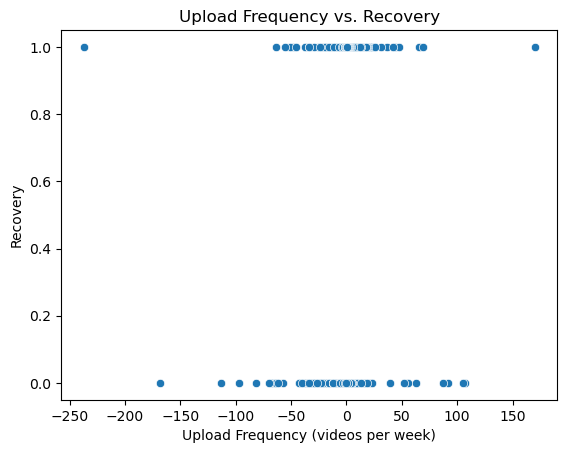

In [67]:
# Analyse relationship between mean frequency difference and recovery
correlation = df_sampled_processed['Mean_frequency_difference'].corr(df_sampled_processed['Recovered'])
print(f'Correlation between Mean Frequency Difference and Recovery: {correlation}')

# Plot the relationship between mean frequency difference and recovery
sns.scatterplot(x='Mean_frequency_difference', y='Recovered', data=df_sampled_processed)
plt.title('Upload Frequency vs. Recovery')
plt.xlabel('Upload Frequency (videos per week)')
plt.ylabel('Recovery')
plt.show()

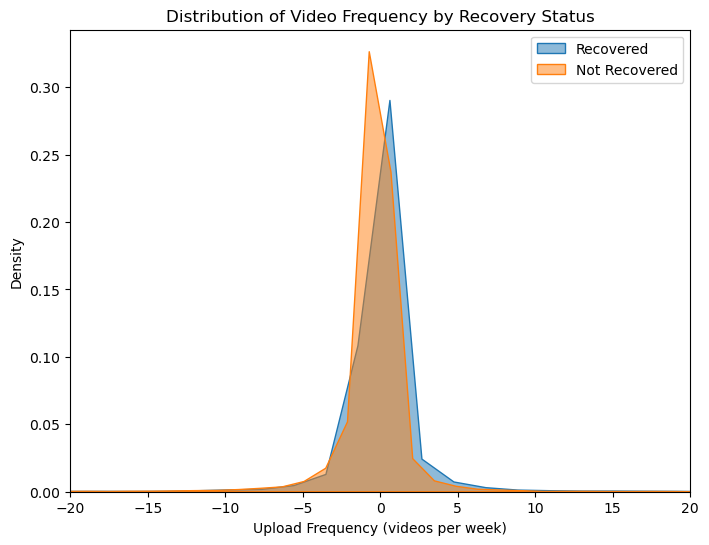

In [68]:
#TODO supprimer si pas pertinent
plt.figure(figsize=(8, 6))
sns.kdeplot(df_sampled[df_sampled['Recovered'] == True]['Mean_frequency_difference'], label='Recovered', fill=True, alpha=0.5)
sns.kdeplot(df_sampled[df_sampled['Recovered'] == False]['Mean_frequency_difference'], label='Not Recovered', fill=True, alpha=0.5)
plt.xlim(-20, 20)
plt.title('Distribution of Video Frequency by Recovery Status')
plt.xlabel('Upload Frequency (videos per week)')
plt.ylabel('Density')
plt.legend()
plt.show()

In order to advise a creator of the number of videos to upload, we should look at the probability to recover of each different frequency of upload

/var/folders/1x/79_xnqb1013dp4j5n3b9fmlw0000gn/T/ipykernel_13379/4275222539.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



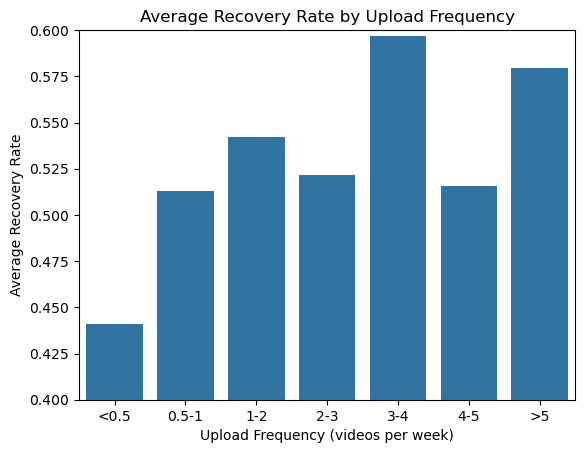

In [69]:
bins = [0, 0.5, 1, 2, 3, 4, 5, 10]
labels = ['<0.5', '0.5-1', '1-2', '2-3', '3-4', '4-5', '>5']

df = df_sampled_processed.copy()

# Bin the upload frequencies
df['Frequency_bin'] = pd.cut(df['Mean_frequency_difference'], bins=bins, labels=labels)

# Calculate the average recovery rate for each bin
recovery_by_frequency = df.groupby('Frequency_bin')['Recovered'].mean().reset_index()

# Plot the recovery rates by upload frequency
sns.barplot(x='Frequency_bin', y='Recovered', data=recovery_by_frequency)
plt.title('Average Recovery Rate by Upload Frequency')
plt.xlabel('Upload Frequency (videos per week)')
plt.ylabel('Average Recovery Rate')
plt.ylim(0.4, 0.6)
plt.show()

In [70]:
current_upload_frequency = df_sampled_processed['Mean_frequency_difference'].mean()

# Example recommendation based on the barplot
if current_upload_frequency < 0.5:
    recommendation = "You should increase your upload frequency to at least 1 video per week to improve your chances of recovery."
elif 0.5 <= current_upload_frequency < 1:
    recommendation = "You are currently uploading less than 1 video per week. Aim to increase your upload frequency to 1-2 videos per week."
elif 1 <= current_upload_frequency < 2:
    recommendation = "You are in the optimal range of 1-2 videos per week. Maintain this frequency to maximize your chances of recovery."
elif 2 <= current_upload_frequency < 3:
    recommendation = "You might want to upload less frequently to 1-2 videos per week to improve your chances of recovery or to upload more frequently to 3-4 videos per week"
else:
    recommendation = "You are uploading more than 3 videos per week. Ensure that you maintain the quality of your content while keeping up with this frequency."

print(recommendation)

You should increase your upload frequency to at least 1 video per week to improve your chances of recovery.


## Q2 : Should I focus on shorter or longer videos? 

Now I know that I should upload more frequently, but what about the duration of my videos 

From the regression, we observed that changing the duration of a video doesn't change much. But let's still be a bit curious and see if we can extract something out of it 

Here we want to visualize if changing the duration of the videos uploaded change the rate of recovery. We observe that if there is no change in the duration of the videos uploaded then the creator has 50% chance of recovery. If the creator posts shorter videos, he has 50% chance of recovery as well and if he posts longer videos then he has 47% chance of recovery. 

So by just visualizing the data, we may want to conclude that during a decline changing the duration of the videos uploaded doesn't change the recovery. 

/var/folders/1x/79_xnqb1013dp4j5n3b9fmlw0000gn/T/ipykernel_13379/1289393978.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



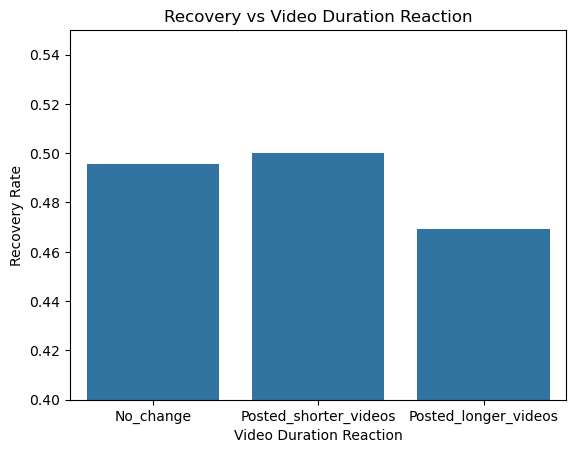

In [71]:
# Plot the relationship between the video duration reaction and recovery
df_reaction_posted_more['Recovered'] = df_reaction_posted_more['Recovered'].astype(int)
sns.barplot(data=df_reaction_posted_more, x='Video_duration_reaction', y='Recovered', errorbar=None)
plt.title('Recovery vs Video Duration Reaction')
plt.xlabel('Video Duration Reaction')
plt.ylabel('Recovery Rate')
plt.ylim(0.4, 0.55)
plt.show()

In [72]:
# change the column name of Mean_duration_difference to mean_video_duration
df.rename(columns={'Mean_duration_difference': 'Mean_video_duration'}, inplace=True)

Correlation between mean video duration and recovery: -0.007647177442809253


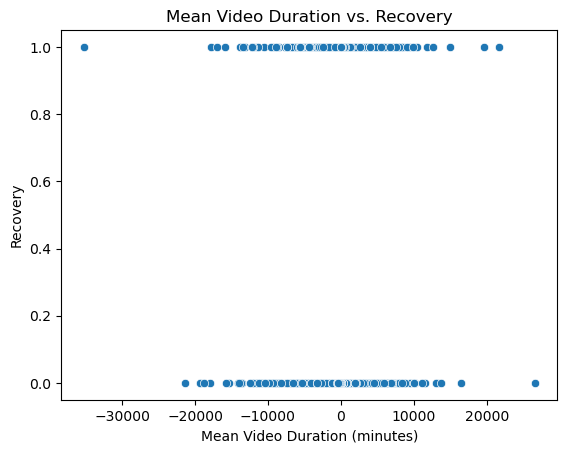

In [73]:
# Calculate the correlation
correlation = df['Mean_video_duration'].corr(df['Recovered'])
print(f'Correlation between mean video duration and recovery: {correlation}')

# Plot the relationship
sns.scatterplot(x='Mean_video_duration', y='Recovered', data=df)
plt.title('Mean Video Duration vs. Recovery')
plt.xlabel('Mean Video Duration (minutes)')
plt.ylabel('Recovery')
plt.show()

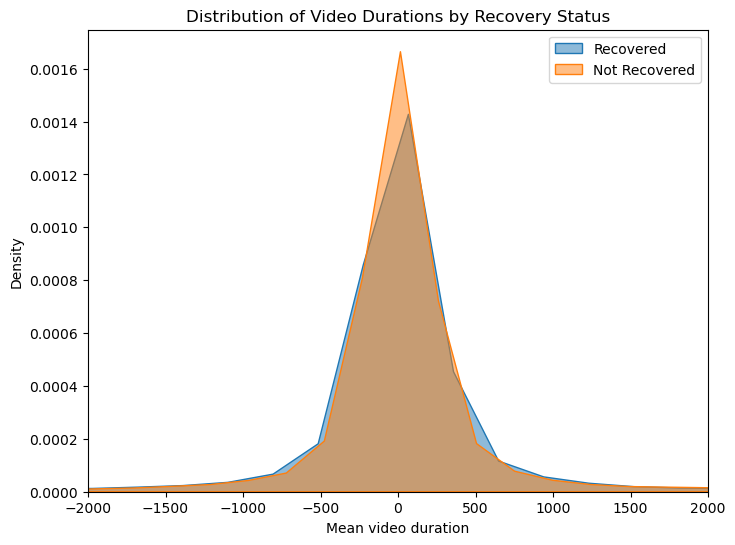

In [74]:
#TODO supprimer si pas pertinent
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df['Recovered'] == True]['Mean_video_duration'], label='Recovered', fill=True, alpha=0.5)
sns.kdeplot(df[df['Recovered'] == False]['Mean_video_duration'], label='Not Recovered', fill=True, alpha=0.5)
plt.xlim(-2000, 2000)
plt.title('Distribution of Video Durations by Recovery Status')
plt.xlabel('Mean video duration')
plt.ylabel('Density')
plt.legend()
plt.show()

In [75]:
df.head()

,Channel,Duration,Recovered,Start,End,Subs_start,Activity_start,Views_start,Mean_video_duration,Posted_longer_videos,...,Category_Howto & Style,Category_Music,Category_News & Politics,Category_Nonprofits & Activism,Category_People & Blogs,Category_Pets & Animals,Category_Science & Technology,Category_Sports,Category_Travel & Events,Frequency_bin
0.0,UC3B6FyoLMLrUYa6i72ccPvw,20,0,189,209,271299.750000,3,1.753062e+07,419.748120,1,...,True,False,False,False,False,False,False,False,False,NaN
1.0,UCIHBFO-XMyTpzXAN-lg8o2g,14,1,112,126,135126.510417,1,2.758465e+07,1432.453191,1,...,False,False,False,False,False,False,False,False,False,NaN
2.0,UC2MjZanWOfyfsrHOyitmXbQ,14,1,128,142,53787.000000,5,3.935174e+06,-177.302463,0,...,False,False,False,False,False,False,False,False,False,<0.5
3.0,UCgUtduvq2Wpc7CDHcGDmZog,15,1,188,203,12262.312500,7,2.818956e+06,-249.533333,0,...,False,False,False,False,False,True,False,False,False,NaN
4.0,UCMn7t0wYUevjBqhK9PUGfHA,19,0,154,173,14582.750000,1,9.031720e+05,-38.000000,0,...,False,True,False,False,False,False,False,False,False,NaN


/var/folders/1x/79_xnqb1013dp4j5n3b9fmlw0000gn/T/ipykernel_13379/3633140429.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



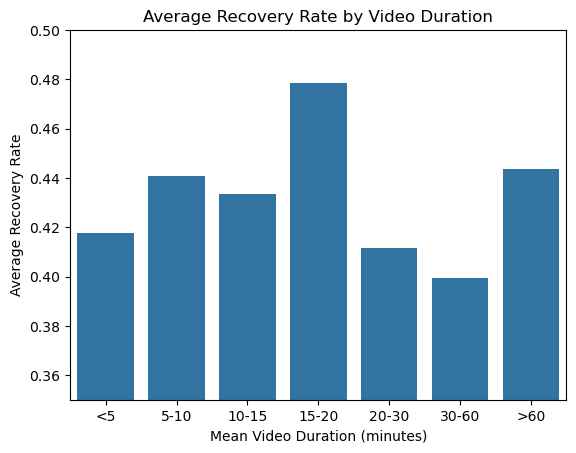

In [76]:
# Define duration bins
duration_bins = [0*60, 5*60, 10*60, 15*60, 20*60, 30*60, 60*60, 120*60]
duration_labels = ['<5', '5-10', '10-15', '15-20', '20-30', '30-60', '>60']

# Bin the video durations
df['Duration_bin'] = pd.cut(df['Mean_video_duration'], bins=duration_bins, labels=duration_labels)

# Calculate the average recovery rate for each bin
recovery_by_duration = df.groupby('Duration_bin')['Recovered'].mean().reset_index()

# Plot the recovery rates by video duration
sns.barplot(x='Duration_bin', y='Recovered', data=recovery_by_duration)
plt.title('Average Recovery Rate by Video Duration')
plt.xlabel('Mean Video Duration (minutes)')
plt.ylabel('Average Recovery Rate')
plt.ylim(0.35, 0.5)
plt.show()

## Q3 : What type of content should i focus on ? 

In [77]:
df_sampled.head()

,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Mean_duration_difference,Posted_longer_videos,Posted_shorter_videos,Mean_frequency_difference,Posted_more,Posted_less,Topic_Change
0.0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.753062e+07,419.748120,True,False,-0.250000,False,False,False
1.0,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,2.758465e+07,1432.453191,True,False,-1.214286,False,False,False
2.0,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,3.935174e+06,-177.302463,False,False,0.428571,False,False,False
3.0,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,2.818956e+06,-249.533333,False,False,-0.600000,False,False,False
4.0,UCMn7t0wYUevjBqhK9PUGfHA,19,False,154,173,Music,14582.750000,1,9.031720e+05,-38.000000,False,False,-0.210526,False,True,False


In [78]:
df = df_sampled.copy()

# Calculate the average recovery rate for each content category
recovery_by_category = df.groupby('Category')['Recovered'].mean().reset_index()

# Sort the categories by recovery rate
recovery_by_category = recovery_by_category.sort_values(by='Recovered', ascending=False)

# Display the recovery rates by category
print(recovery_by_category)


                 Category  Recovered
8         News & Politics   0.487985
5                  Gaming   0.463433
12   Science & Technology   0.454318
0        Autos & Vehicles   0.449905
6           Howto & Style   0.442514
14        Travel & Events   0.439776
1                  Comedy   0.435897
10         People & Blogs   0.432520
13                 Sports   0.432000
3           Entertainment   0.421364
11         Pets & Animals   0.411765
4      Film and Animation   0.406863
2               Education   0.382353
9   Nonprofits & Activism   0.376471
7                   Music   0.319603


/var/folders/1x/79_xnqb1013dp4j5n3b9fmlw0000gn/T/ipykernel_13379/1160256678.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




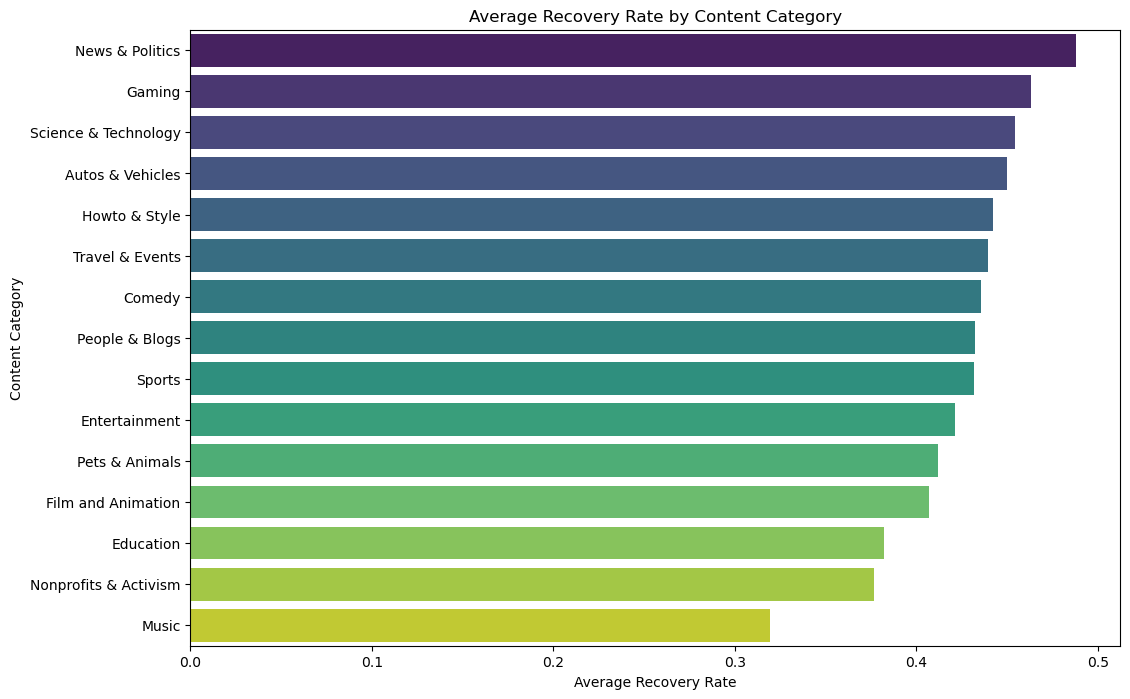

In [79]:
# Plot the recovery rates by content category
plt.figure(figsize=(12, 8))
sns.barplot(x='Recovered', y='Category', data=recovery_by_category, palette='viridis')
plt.title('Average Recovery Rate by Content Category')
plt.xlabel('Average Recovery Rate')
plt.ylabel('Content Category')
plt.show()

In [80]:
# Example recommendation based on the barplot
high_recovery_categories = recovery_by_category[recovery_by_category['Recovered'] > 0.45]['Category'].tolist()
low_recovery_categories = recovery_by_category[recovery_by_category['Recovered'] <= 0.45]['Category'].tolist()

recommendation = f"To maximize your chances of recovery, focus on creating content in the following categories: {', '.join(high_recovery_categories)}. These categories have shown higher recovery rates. Consider avoiding or minimizing content in the following categories: {', '.join(low_recovery_categories)}, as they have shown lower recovery rates."

print(recommendation)

To maximize your chances of recovery, focus on creating content in the following categories: News & Politics, Gaming, Science & Technology. These categories have shown higher recovery rates. Consider avoiding or minimizing content in the following categories: Autos & Vehicles, Howto & Style, Travel & Events, Comedy, People & Blogs, Sports, Entertainment, Pets & Animals, Film and Animation, Education, Nonprofits & Activism, Music, as they have shown lower recovery rates.


## Q? : Should I change the topic of my videos? 

### How does a change of topic influence the recovery?

/var/folders/1x/79_xnqb1013dp4j5n3b9fmlw0000gn/T/ipykernel_13379/379739260.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




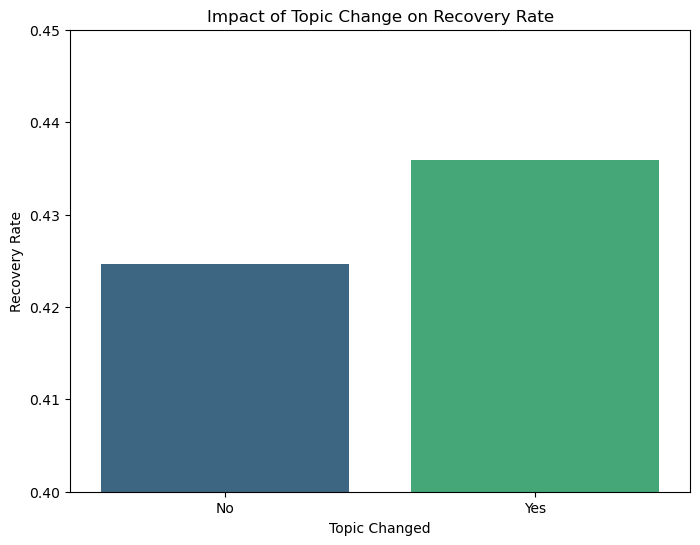

   Topic_Change  Recovered
0         False   0.424674
1          True   0.435916


In [81]:
df_reactions_topics = pd.merge(df_reactions, topic_change_data, left_index=True, right_on='Decline', how='left')
df_reactions_topics = df_reactions_topics.dropna()

change_vs_unchanged = df_reactions_topics.groupby('Topic_Change')['Recovered'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Topic_Change', y='Recovered', data=change_vs_unchanged, palette='viridis')
plt.title('Impact of Topic Change on Recovery Rate')
plt.xlabel('Topic Changed')
plt.ylabel('Recovery Rate')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylim(0.4, 0.45)
plt.show()

print(change_vs_unchanged.head())

Very small variation, not statistically significant \
BUT maybe different topic transitions have different correlations with the recovery

### Analysis of different toopic changes

In [82]:
df_reactions_changed_topic = df_reactions_topics[df_reactions_topics['Topic_Change'] == True]
df_reactions_changed_topic = df_reactions_changed_topic.drop(columns=['Decline', 'Topic_Change'])
df_reactions_changed_topic = df_reactions_changed_topic.dropna()
df_reactions_changed_topic.head()

,Channel,Duration,Start,End,Recovered,Mean_duration_difference,Mean_frequency_difference,Videos_per_week_before,Videos_per_week_after,Mean_duration_before,Mean_duration_after,Frequency_reaction,Video_duration_reaction,Topic_Before,Topic_After
5.0,UCEkfvGbHtngMQJ5t4wsBY0Q,19,190,209,False,63.454559,-0.105263,6.210526,6.105263,524.864407,588.318966,No_change,No_change,11.0,13.0
7.0,UCgqv_8dYjKNkcC9DcU99R8g,11,199,210,True,8.466667,-0.090909,0.545455,0.454545,416.333333,424.800000,No_change,No_change,7.0,13.0
11.0,UCWxG3l_NRgrLuZjo6Hk_OLw,11,112,123,True,-19.356150,0.363636,4.636364,5.000000,315.647059,296.290909,No_change,No_change,11.0,5.0
15.0,UCML3sc7SIGyOyHvVyR74M7g,11,89,100,True,2100.000000,0.000000,0.090909,0.090909,1244.000000,3344.000000,No_change,Posted_longer_videos,10.0,4.0
22.0,UCr2UGJPBrfr8J0fdDkQqbyQ,24,147,171,False,76.289231,-0.500000,1.041667,0.541667,637.480000,713.769231,No_change,No_change,11.0,5.0


In [83]:
# Group by Topic_Before and Topic_After to calculate recovery rates
topic_transitions = df_reactions_changed_topic.groupby(['Topic_Before', 'Topic_After']).agg(
    recovery_rate=('Recovered', 'mean'),
    count=('Recovered', 'size')
).reset_index()

# Filter for meaningful transitions, with more than 10 cases
topic_transitions = topic_transitions[topic_transitions['count'] > 10]
topic_transitions.head()

,Topic_Before,Topic_After,recovery_rate,count
2,0.0,3.0,0.422222,45
5,0.0,6.0,0.227273,22
6,0.0,7.0,0.214286,14
10,0.0,11.0,0.421053,19
14,0.0,15.0,0.540541,37


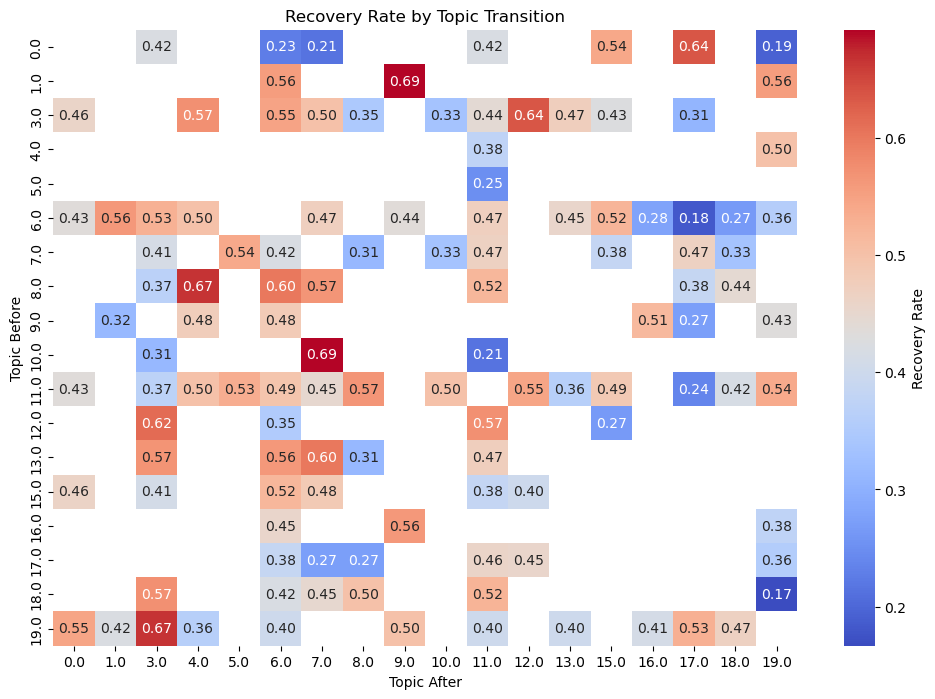

In [84]:
pivot_data = topic_transitions.pivot(
    index='Topic_Before', 
    columns='Topic_After', 
    values='recovery_rate'
)

# Heatmap of the recovery rates by topic transitions
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Recovery Rate'})
plt.title('Recovery Rate by Topic Transition')
plt.xlabel('Topic After')
plt.ylabel('Topic Before')
plt.show()

/var/folders/1x/79_xnqb1013dp4j5n3b9fmlw0000gn/T/ipykernel_13379/3043787825.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




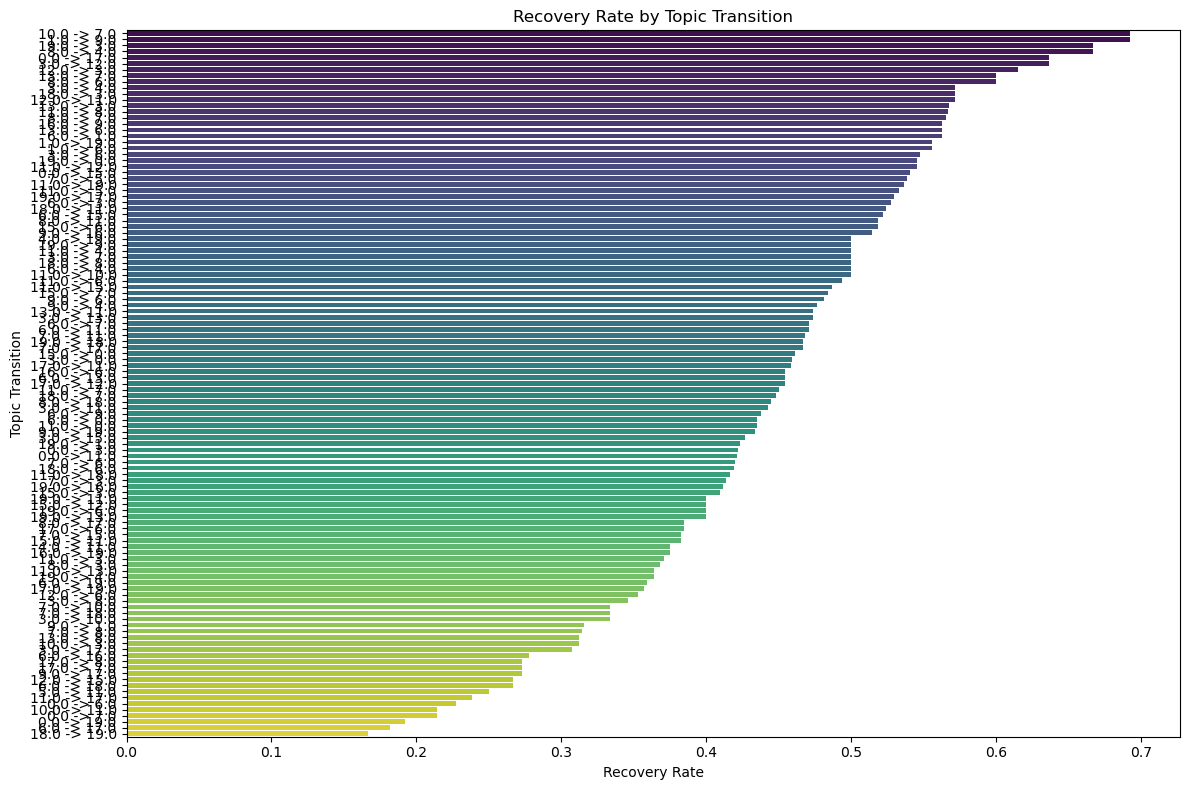

In [85]:
# Sort transitions by recovery rate
sorted_transitions = topic_transitions.sort_values(by='recovery_rate', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=sorted_transitions,
    x='recovery_rate',
    y=sorted_transitions.apply(lambda row: f"{row['Topic_Before']} -> {row['Topic_After']}", axis=1),
    palette='viridis'
)
plt.title('Recovery Rate by Topic Transition')
plt.xlabel('Recovery Rate')
plt.ylabel('Topic Transition')
plt.tight_layout()
plt.show()

In [86]:
import plotly.express as px

fig = px.bar(
    sorted_transitions,
    x='recovery_rate',
    y=sorted_transitions.apply(lambda row: f"{row['Topic_Before']} -> {row['Topic_After']} (n={row['count']})", axis=1),
    orientation='h',
    title='Recovery Rate by Topic Transition',
    labels={'x': 'Recovery Rate', 'y': 'Topic Transition'},
    hover_data=['count']
)
fig.update_layout(height=1000) 
fig.show()
